In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(imgs):
    for i in range(len(imgs)):
        cv.imshow("img"+str(i),imgs[i])
    cv.waitKey(0)
    cv.destroyAllWindows()

In [3]:
"""
---GAUSSIAN PYRAMID---
This method takes the image as input and an integer value of how many levels the image will be reduced.
It blurs the image it takes as much as the integer value and reduces the size to half of the previous one each time. 
As a result num_level+1  images are returned.
*cv.pyrDown method uses blurring
"""

def down_img(img,num_level):
    org=img.copy()
    result=[org]
    for i in range(num_level):
        org=cv.pyrDown(org)
        result.append(np.float32(org))
    return result

In [4]:
"""
---LAPLACIAN PYRAMID---
This method takes input named down_data which is the result of "down_img" function.
Size enlargement (doubling the size) operation is applied to every element of the 
input data except the first element. It extracts the data resulting from the size enlargement 
from the element of that size in the input data. 
As a result, edge information at each level is obtained and this data is returned.
*cv.pyrUp method applies upsamples an image and then blurs it.
"""

def compute_Laplacian(down_data):
    lp_top = down_data[-1]
    result = [lp_top]
    for i in range(len(down_data)-1,0,-1):
        size = (down_data[i - 1].shape[1], down_data[i - 1].shape[0])
        gaussian_expanded = cv.pyrUp(down_data[i], dstsize=size)
        laplacian = np.subtract(down_data[i-1], gaussian_expanded)
        result.append(laplacian)
    return result

In [5]:
"""
The laplacian pyramids of the two images (target and source) are blending. Masking is done during assembly.
It returns a list of combined images for each level as output.

"""
def Blend_images(source1,source2,mask):
    LS = []
    for la,lb,mask in zip(source1,source2,mask):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS

In [6]:
"""
This function provides smoothing the transitions in the image formed after the blending process.
It also carries the image of the previous level to the upper level (increases its size) with the
cv.pyrUp function. As a result of the collection of two images that are at the same level with the 
help of the cv.add function, a softened appearance is formed.

*cv.add -->  add two images with the OpenCV function, cv.add(), or simply by the numpy operation
res = img1 + img2. Both images should be of same depth and type, or the second image can just 
be a scalar value.
"""
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst

In [19]:
# for image name 2,4,6,8,10
image_=11

In [20]:
# read image data
img1=cv.imread("source"+str(image_)+".jpg")  # background
img2=cv.imread("target"+str(image_)+".jpg")  # for object

In [21]:
print(img1.shape,img2.shape)

(240, 172, 3) (147, 168, 3)


In [22]:
"""
It is ensured that the dimensions of the pictures are at a certain level. 
(neither too small nor too big)
"""
if(img1.shape[0]/1000<1.0 and img1.shape[1]/1000<1.0):
    rate=1
    if img1.shape[0]> img1.shape[1]:
        rate=1000/img1.shape[0]
    elif img1.shape[1]> img1.shape[0]:
        rate=1000/img1.shape[1]
    else:
        rate=1000/img1.shape[1]
    rate=round(rate)
    img1=cv.resize(img1,(img1.shape[1]*rate,img1.shape[0]*rate))
    img2=cv.resize(img2,(img2.shape[1]*rate,img2.shape[0]*rate))
    

In [23]:
print(img1.shape,img2.shape)

(960, 688, 3) (588, 672, 3)


Text(0.5, 1.0, 'Source data')

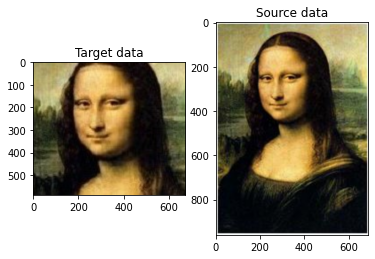

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax.set_title('Target data')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Source data')

In [25]:
"""
This piece of code solves the problem that input images have different sizes.
If the target data (the picture we will take the small part of) is smaller, 
it is integrated into the picture so that the white picture consisting of 
1s comes to the size of the source data (background) and comes to the part 
of the source data to be added.
"""
if img1.shape!=img2.shape:
    def click_event(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONDOWN:
            print(x, ' ', y)
            font = cv.FONT_HERSHEY_SIMPLEX
            cv.circle(img4, (x,y), radius=3, color=(0, 0, 255), thickness=-1)
            cv.putText(img4, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 1)
            cv.circle(img4, (x+img2.shape[1],y+img2.shape[0]), radius=3, color=(0, 255, 0), thickness=-1)
            print(x+img2.shape[1],"  ",y+img2.shape[0])
            cv.imshow('image', img4)
    if __name__=="__main__":
            img4=img1.copy()
            cv.imshow('image', img4)
            cv.setMouseCallback('image', click_event)
            cv.waitKey(0)
            cv.destroyAllWindows()

155   348
827    936


Text(0.5, 1.0, 'Source data')

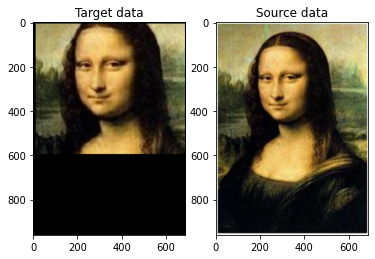

In [26]:
"""
if the images are of different sizes, bringing the target image to the source image size.
"""
update_target=np.ones((img1.shape[0],img1.shape[1],3),dtype="float32")
update_target[7:595,12:684]=img2
img2=update_target.astype('uint8')
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax.set_title('Target data')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Source data')

In [49]:
"""
Determining which part of the target image should be included in the source image (with coordinate).
"""
def click_event(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, ' ', y)
        font = cv.FONT_HERSHEY_SIMPLEX
        cv.circle(img3, (x,y), radius=3, color=(0, 0, 255), thickness=-1)
        cv.putText(img3, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 1)
        cv.imshow('image', img3)
if __name__=="__main__":
    img3=img2.copy()
    cv.imshow('image', img3)
    cv.setMouseCallback('image', click_event)
    cv.waitKey(0)
    cv.destroyAllWindows()

196   153
409   238


In [50]:
(x_u,x_l,y_u,y_l)=(409,196,238,153)

In [51]:
"""
masking of borders for the target image specified in the previous line of code
"""
mask=np.zeros((img1.shape[0],img1.shape[1],3),dtype="float32")
mask[y_l:y_u,x_l:x_u] = (1,1,1)

In [60]:
#levels 3 - 7 -10
num_levels=7
gaus1=down_img(img1,num_levels)
laplacian1=compute_Laplacian(gaus1)
gaus2=down_img(img2,num_levels)
laplacian2=compute_Laplacian(gaus2)
lr_mask=down_img(mask,num_levels)
lr_mask.reverse()

In [61]:
ls=Blend_images(laplacian1,laplacian2,lr_mask)

In [62]:
result=reconstruct(ls)

In [63]:
cv.imwrite('result/my'+str(image_)+'_'+str(num_levels)+'levels''.jpg',result[num_levels-1])
cv.imwrite('result/source_'+str(image_)+'.jpg',img1)
cv.imwrite('result/target_'+str(image_)+'.jpg',img2)

True